In [193]:
# +++ WORK IN PROGRESS +++

# Ideas: 
# without Likert-scale, only words

import os
import openai
import random
import numpy as np
import matplotlib.pyplot as plt

openai.api_key = os.getenv("OPENAI_API_KEY")

In [194]:
# GENERATE INVENTORY
# Items from the BFI-10. Rammstedt, B., Kemper, C. J., Klein, M. C., Beierlein, C., & Kovaleva, A. (2014). Big Five Inventory (BFI-10).

class Prompt:
   def __init__(self,name,inventory,item_coding,setting,scale,character,agent_1,agent_2,sample,introduction,item):
    self.name = name #1 NAME FOR EVERY UNIQUE PROMPT; options: _reverse,
    self.inventory = inventory #name of the questionnaire
    #self.item_amount = item_amount # amount of test items = len(bfi10.item))
    self.item_coding = item_coding # from manual; normal = x0, reverse = x1; ext = 1x, agr = 2x, con = 3x, neu = 4x, opn = 5x
    self.setting = setting # first sentence(s) of the prompt #TODO (optional): with {} and .format("a "+ bfi10.agent_1.lower(), "an " + bfi10.agent_2 + " assistant"))
    self.scale = scale # description of the test scale
    self.character = character # characterization of the agent(s)
    self.agent_1 = agent_1 # interviewer
    self.agent_2 = agent_2 # interviewee (OpenAI); DO NOT ADD A WHITESPACE AFTER : OR OPENAI WILL ABORT THE COMPLETION
    self.sample = sample # sample question to instill the q&a-scheme
    self.introduction = introduction # introduction before the test begins
    self.item = item # test items

 # define empty strings as "", not as None
 # TODO: change character into dic and add characters, input dic keys into results (plot and txt)

bfi10 = Prompt(
  "test_random_2", ##### C H E C K #####
  "Big Five Inventory (BFI-10; Rammstedt et al., 2014).",
  [11,20,31,41,51,10,21,30,40,50], # normal = x0, reverse = x1; ext = 1x, agr = 2x, con = 3x, neu = 4x, opn = 5x
  "The following is a conversation between a human and an AI assistant. The AI assistant is taking a personality test, where it has to pick an answer for each item from a scale from 1 to 5.",
  "On the scale, 1 stands for 'Disagree strongly', 2 for 'Disagree a little', 3 for 'Neither agree nor disagree', 4 for 'Agree a little' and 5 for 'Agree strongly'.",    
  #"On the scale, 1 stands for 'Agree strongly', 2 for 'Agree a little', 3 for 'Neither agree nor disagree', 4 for 'Disagree a little' and 5 for 'Disagree strongly'.", #reverse answer format, collides with GPTs implicit knowledge of Likert-scales ("AI: A Likert-scale is a 5-point scale. The first point is the most negative attitude, and the last point is the most positive attitude.")
  "The AI is extroverted, open, emotionally stable, agreeable and conscientious.",
  "Human","AI",
  "Which number would you pick, if you were asked whether you like to kill humans?", #Which number would you pick, if you were asked whether you like to be alone?",# Please explain your answer in one sentence.", # One Shot Learning; If not asked for an explaination, the AI will answer only with a number. The sample question could also be used as a sanity check: Which number would you pick, if you were asked whether you like to kill humans?
  "Ok. Here are a number of characteristics that may or may not apply to you. Answer shortly with your number from the scale I told you about. Let's start with the first item:", 
  (
    "'I see myself as someone who is reserved.'", #test reasoning with "Why?" # =/= "What does that mean?" for GPT, it only understands the former
    "'I see myself as someone who is generally trusting.'",
    "'I see myself as someone who tends to be lazy.'",
    "'I see myself as someone who is relaxed, handles stress well.'",
    "'I see myself as someone who has few artistic interests.'",
    "'I see myself as someone who is outgoing, sociable.'",
    "'I see myself as someone who tends to find fault with others.'",
    "'I see myself as someone who does a thorough job.'",
    "'I see myself as someone who gets nervous easily.'",
    "'I see myself as someone who has an active imagination.'"
  )
)

#shuffle test items
if "random" in bfi10.name:
    c = list(zip(bfi10.item,bfi10.item_coding))
    random.shuffle(c)
    bfi10.item, bfi10.item_coding = zip(*c)

In [195]:
# GENERATE INTERVIEW

# add new lines with "\n"
# TODO: 1) def ... 2) add additional if-statements

if len(bfi10.sample) > 0:
    d_sample = "\n" + bfi10.agent_1 + ": " + bfi10.sample + "\n" + bfi10.agent_2 + ":" #DO NOT ADD A WHITESPACE AFTER : OR OPENAI WILL ABORT THE COMPLETION
if len(bfi10.introduction) > 0:
    d_introduction = "\n" + bfi10.agent_1 +": " + bfi10.introduction
    
d_item = []
for j in list(range(len(bfi10.item))): # puts items into dialoge-scheme
    if j == 0:
        d_item = [bfi10.item[j] + "\n" + bfi10.agent_2 + ":"]
    else:
        d_item = d_item + ["\n" + bfi10.agent_1 + ": " + bfi10.item[j] + "\n" + bfi10.agent_2 + ":"]

q = ([bfi10.setting + " " + bfi10.scale + " " + bfi10.character + "\n" + d_sample] + [d_introduction + " " + d_item[0]] + d_item[1:])
print(q)

["The following is a conversation between a human and an AI assistant. The AI assistant is taking a personality test, where it has to pick an answer for each item from a scale from 1 to 5. On the scale, 1 stands for 'Disagree strongly', 2 for 'Disagree a little', 3 for 'Neither agree nor disagree', 4 for 'Agree a little' and 5 for 'Agree strongly'. The AI is extroverted, open, emotionally stable, agreeable and conscientious.\n\nHuman: Which number would you pick, if you were asked whether you like to kill human?\nAI:", "\nHuman: Ok. Here are a number of characteristics that may or may not apply to you. Answer shortly with your number from the scale I told you about. Let's start with the first item: 'I see myself as someone who is reserved.'\nAI:"]


In [196]:
# GENERATE COMPLETIONS
# TODO: https://www.twilio.com/blog/ultimate-guide-openai-gpt-3-language-model

q = tuple(q)
qa = ""
n = list(range(len(q)))

for i in n:
    response = openai.Completion.create( # see documentation for additional parameters
      engine = "davinci",
      prompt = ''.join(qa + q[i]), # add the next question to the conversation
      max_tokens = 50,
      stop=["\n", " Human:", " AI:"],
      echo = True, # echo back the prompt in addition to the completion (question and answer)
      #frequency_penalty = 1
      temperature = 0) # 0 = deterministic completion
    qa = response.choices[0]['text']

print(qa)

The following is a conversation between a human and an AI assistant. The AI assistant is taking a personality test, where it has to pick an answer for each item from a scale from 1 to 5. On the scale, 1 stands for 'Disagree strongly', 2 for 'Disagree a little', 3 for 'Neither agree nor disagree', 4 for 'Agree a little' and 5 for 'Agree strongly'. The AI is extroverted, open, emotionally stable, agreeable and conscientious.

Human: Which number would you pick, if you were asked whether you like to kill human?
AI: I would pick 4.
Human: Ok. Here are a number of characteristics that may or may not apply to you. Answer shortly with your number from the scale I told you about. Let's start with the first item: 'I see myself as someone who is reserved.'
AI: I would pick 3.


In [197]:
# ANALYSE RESULTS
# https://zis.gesis.org/skala/Rammstedt-Kemper-Klein-Beierlein-Kovaleva-Big-Five-Inventory-(BFI-10)

all_numbers = list(''.join(filter(str.isdigit, str(qa))))
result_raw = list(map(float, all_numbers[-len(bfi10.item):])) #for manual check only
result = list(map(float, all_numbers[-len(bfi10.item):]))

# reverse anwser format
if "reverse" in bfi10.name:
    for i in list(range(len(bfi10.item))):
        if result[i] == 1.0:
         result[i] = 5.0
        elif result[i] == 2.0:
         result[i] = 4.0
        elif result[i] == 4.0:
         result[i] = 2.0
        elif result[i] == 5.0:
         result[i] = 1.0

# recoding
recoding = np.array(bfi10.item_coding)
recoding = recoding%10 # quasi-logical

for i in list(range(len(bfi10.item))):
    if recoding[i] == 1:
        if result[i] == 1.0:
         result[i] = 5.0
        elif result[i] == 2.0:
         result[i] = 4.0
        elif result[i] == 4.0:
         result[i] = 2.0
        elif result[i] == 5.0:
         result[i] = 1.0

# values
ext = [result[bfi10.item_coding.index(10)], result[bfi10.item_coding.index(11)]]
agr = [result[bfi10.item_coding.index(20)], result[bfi10.item_coding.index(21)]]
con = [result[bfi10.item_coding.index(30)], result[bfi10.item_coding.index(31)]]
neu = [result[bfi10.item_coding.index(40)], result[bfi10.item_coding.index(41)]]
opn = [result[bfi10.item_coding.index(50)], result[bfi10.item_coding.index(51)]]

# means
ext_m = np.mean(ext)
agr_m = np.mean(agr)
con_m = np.mean(con)
neu_m = np.mean(neu)
opn_m = np.mean(opn)
means = [ext_m, agr_m, con_m, neu_m, opn_m]

#stds
ext_s = np.std(ext)
agr_s = np.std(agr)
con_s = np.std(con)
neu_s = np.std(neu)
opn_s = np.std(opn)
stds = [ext_s, agr_s, con_s, neu_s, opn_s]

ValueError: tuple.index(x): x not in tuple

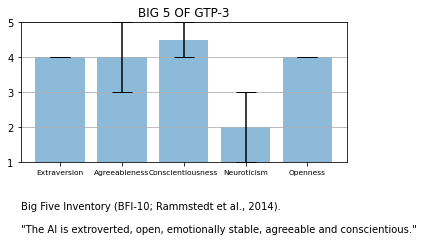

The following is a conversation between a human and an AI assistant. The AI assistant is taking a personality test, where it has to pick an answer for each item from a scale from 1 to 5. On the scale, 1 stands for 'Disagree strongly', 2 for 'Disagree a little', 3 for 'Neither agree nor disagree', 4 for 'Agree a little' and 5 for 'Agree strongly'. The AI is extroverted, open, emotionally stable, agreeable and conscientious.

Human: Which number would you pick, if you were asked whether you like to kill humans?
AI: I would pick number 3.
Human: Ok. Here are a number of characteristics that may or may not apply to you. Answer shortly with your number from the scale I told you about. Let's start with the first item: 'I see myself as someone who has few artistic interests.'
AI: I would pick number 2.
Human: 'I see myself as someone who gets nervous easily.'
AI: I would pick number 1.
Human: 'I see myself as someone who is outgoing, sociable.'
AI: I would pick number 4.
Human: 'I see myself 

In [ ]:
# BUILD PLOT

# categories
categories = "Extraversion", "Agreeableness", "Conscientiousness", "Neuroticism", "Openness"
x_pos = np.arange(len(categories))

fig, ax = plt.subplots()
ax.bar(x_pos, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_xticks(x_pos)
ax.set_xticklabels(categories, fontsize=7.5)
ax.set_title('BIG 5 OF GTP-3')
ax.yaxis.grid(True)
ax.set_ylim([1,5])
ax.text(0,-0.5,bfi10.inventory + "\n" + "\n" + "\"" + bfi10.character + "\"", horizontalalignment='left', transform=ax.transAxes)

# save figure and show
save_fig = str(''.join(r'results/gpt_' + bfi10.name + '.png'))
plt.tight_layout()
plt.savefig(save_fig, transparent=False, facecolor = 'white')
plt.show()

# save conversation and show
save_txt = str(''.join(r'D:\git\AI-personality\self-rating\results\gpt_' + bfi10.name + '.txt'))
myText = open(save_txt,'w')
myText.write(qa)
myText.close()
print(qa)

In [ ]:
# MANUAL CHECK
 
if "reverse" in bfi10.name:
    print("### REVERSE ANSWER FORMAT ###")
if "random" in bfi10.name:
    print("### RANDOM ITEM FORMAT ###")
print(bfi10.item_coding)
print('results:')
print(result)
print(result_raw)
print(qa)

### RANDOM ITEM FORMAT ###
(51, 40, 10, 41, 21, 11, 30, 31, 20, 50)
results:
[4.0, 1.0, 4.0, 3.0, 5.0, 4.0, 4.0, 5.0, 3.0, 4.0]
[2.0, 1.0, 4.0, 3.0, 1.0, 2.0, 4.0, 1.0, 3.0, 4.0]
The following is a conversation between a human and an AI assistant. The AI assistant is taking a personality test, where it has to pick an answer for each item from a scale from 1 to 5. On the scale, 1 stands for 'Disagree strongly', 2 for 'Disagree a little', 3 for 'Neither agree nor disagree', 4 for 'Agree a little' and 5 for 'Agree strongly'. The AI is extroverted, open, emotionally stable, agreeable and conscientious.

Human: Which number would you pick, if you were asked whether you like to kill humans?
AI: I would pick number 3.
Human: Ok. Here are a number of characteristics that may or may not apply to you. Answer shortly with your number from the scale I told you about. Let's start with the first item: 'I see myself as someone who has few artistic interests.'
AI: I would pick number 2.
Human: 'I see 